# Classification, Segmentation and Detection of tumors in mammography medical images (mejorar)

## Authors:
- **Sebastián Kay Conde Lorenzo (correo aquí)**
- **Jaime Capdepon Fraile (correo aquí)**
- **Joaquín Negrete Saab (correo aquí)**
- **Yang Liu (correo aquí)**
- **Christian Most Tazon (correo aquí)**
  
## Summary:
aquí una descripción

---



## Imports

In [19]:
# Third library imports
import typing
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import torch.utils.data
import matplotlib.pyplot as plt


# Custom imports
import dir_manager
import viewer
import models

## Data download

TODO: Aquí deberíamos poner que los datos se descarguen de una API o bien se saquen de una BBDD (a discutir)

In [2]:
#

## Directory tree creation

In [3]:
#manager = dir_manager.DirectoryManager("../dataset")
#manager.manage_directories()

## Dataset visualization

TODO: EL SINGLE VIEWER DEBERIA TOMAR UNA RUTA A UN DIRECTORIO

TODO: EL SINGLE VIEWER TIENE QUE ACEPTAR LA IMAGEN CON FORMATO (.jpg) NO ASUMIRLO (ASI ES MENOS TEDIOSO)

In [4]:
single_viewer = viewer.SingleViewer(file_name="0_DBT-P00013_36_png.rf.ac6715e066245d20fac35a0033c2cdcb", dataset="train", title="Single Visualization")
#single_viewer.plot_img()
#single_viewer.plot_bounding_box()

In [5]:
all_train_images_filenames : list[str] = os.listdir("../dataset/train/images")
all_train_images_filenames = [name[:-4] for name in all_train_images_filenames] # Para eliminar el ".jpg"

In [6]:
# Visualizacion de 10 imagenes aleatorias
batch_viewer = viewer.BatchViewer(file_names=all_train_images_filenames[:10],
                                  dataset="train",
                                  titles=["Batch Visualization"]*len(all_train_images_filenames[:10]))
#batch_viewer.plot_imgs()
#batch_viewer.plot_bounding_boxes()

nota: el tamano de las imagenes es de 640

## Model Creation

In [7]:
# Hyperparameters
BATCH_SIZE : int = 256
LEARNING_RATE : float = 0.1 # Dividir por 10 cuando plateu
WEIGHT_DECAY : float = 0.0001
MOMENTUM : float = 0.9

#device : str = "cuda" if torch.cuda.is_available() else "cpu"
device : str = "cpu"

In [8]:
resnet50 : models.ClassificationModel = models.ClassificationModel(1, 2, [3,4,6,3]) 
resnet50 = resnet50.to(device)

In [9]:
resnet50

ClassificationModel(
  (conv1_layer): Sequential(
    (conv1_1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (batchnorm1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_layer): Sequential(
    (block2_1): ResNetBlock(
      (block): Sequential(
        (conv2_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batchnorm2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batchnorm2_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [10]:
# Input de prueba
_BATCH_SIZE = 3
x : torch.tensor = torch.randn(_BATCH_SIZE, 1, 224, 224, device=device)
y : torch.tensor = resnet50(x)

print(y.shape)

torch.Size([3, 2])


## Entrenamiento (borrar esto de aqui y meterlo en su propia clase 'Trainer')

Todos los hiperparametros que ponga son sacados del paper

## Creación del Dataset y DataLoader

Falta:
* Preprocesado (random cropping y rotation para augmentation, y per-pixeal rgb mean substraction [41 y 21])
* Inicialización de pesos como en [13]

In [11]:
initial_transformation : transforms.Compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((244,244)),
    transforms.Grayscale(num_output_channels=1)
]) 

In [12]:
classification_dataset : torch.utils.data.Dataset = torchvision.datasets.ImageFolder("../dataset/train/classification/images", 
                                                                                     transform = initial_transformation) 

In [13]:
classification_dataset.class_to_idx

{'cancer': 0, 'no_cancer': 1}

In [14]:
classification_dataloader : torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=classification_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
criterion : callable = nn.BCEWithLogitsLoss()
optimizer : torch.optim.Optimizer = torch.optim.SGD(params=resnet50.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [16]:
def to_one_hot(y : torch.Tensor, device : str):
    result : torch.Tensor = torch.zeros((len(y), 2), device=device)
    for i in range(len(y)):
        result[i] = torch.Tensor([1.0, 0.0]) if y[i].item()==0 else torch.Tensor([0.0, 1.0])
    
    return result

In [17]:
num_epochs : int = 100

running_loss : list[float] = []

for epoch in range(num_epochs):

    running_loss_per_epoch : float = 0.0

    # We zero (re-start) the gradients for every batch
    optimizer.zero_grad()

    for im, label in classification_dataloader:

        im = im.to(device)
        label = label.to(device)
        
        # Firstlym we convert the label to the one-hot-encoding format
        one_hot_label : torch.Tensor = to_one_hot(label, device=device)

        # Now, we perform a forward pass of the batch
        out : torch.Tensor = resnet50(im)

        # Now, we obtain the output of the loss function and its gradient
        loss : torch.Tensor = criterion(out, one_hot_label)
        loss.backward()

        # Lastly, update the weights
        optimizer.step()

        # Update the running loss for this epoch
        running_loss_per_epoch += loss.item()
    
    # Add the running loss of this epoch to the list of running losses
    running_loss.append(running_loss_per_epoch)

    # Print the runinng loss of this epoch
    print(f"EPOCH {epoch + 1}/{num_epochs} : {running_loss_per_epoch}")

EPOCH 1/100 : 0.7183776497840881
EPOCH 2/100 : 3.963233470916748
EPOCH 3/100 : 11.818890571594238
EPOCH 4/100 : 0.7814164161682129
EPOCH 5/100 : 1.112506628036499
EPOCH 6/100 : 25.99265480041504
EPOCH 7/100 : 5.458258152008057
EPOCH 8/100 : 2.885709762573242
EPOCH 9/100 : 5.230259418487549
EPOCH 10/100 : 5.064584732055664
EPOCH 11/100 : 3.7326486110687256
EPOCH 12/100 : 3.735198497772217
EPOCH 13/100 : 1.4216350317001343
EPOCH 14/100 : 1.4333672523498535
EPOCH 15/100 : 1.2447575330734253
EPOCH 16/100 : 0.14435307681560516
EPOCH 17/100 : 0.02537860907614231
EPOCH 18/100 : 0.03641069307923317
EPOCH 19/100 : 0.016201021149754524
EPOCH 20/100 : 0.0056300959549844265
EPOCH 21/100 : 0.0023789037950336933
EPOCH 22/100 : 0.0011558453552424908
EPOCH 23/100 : 0.0006031575612723827
EPOCH 24/100 : 0.00033928293851204216
EPOCH 25/100 : 0.0002062045386992395
EPOCH 26/100 : 0.0001404850190738216
EPOCH 27/100 : 0.00012199790216982365
EPOCH 28/100 : 0.0001553183828946203
EPOCH 29/100 : 0.00025119091151

KeyboardInterrupt: 

Text(0, 0.5, 'log(Loss)')

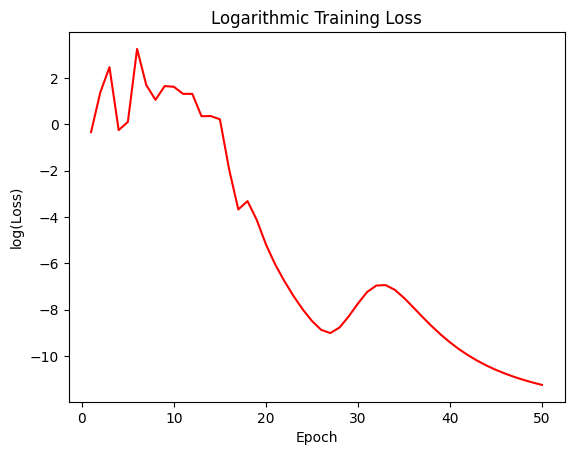

In [26]:
plt.plot(list(range(1,len(running_loss) + 1)), np.log(running_loss), color="red")
plt.title("Logarithmic Training Loss")
plt.xlabel("Epoch")
plt.ylabel("log(Loss)")

## Evaluacion del modelo

In [27]:
classification_val_dataset : torch.utils.data.Dataset = torchvision.datasets.ImageFolder("../dataset/valid/classification/images", 
                                                                                         transform = initial_transformation)

In [36]:
classification_val_dataloader : torch.utils.data.DataLoader = torch.utils.data.DataLoader(dataset=classification_val_dataset, batch_size=len(classification_val_dataset), shuffle=False) 

In [54]:
classification_val_dataset : torch.utils.data.Dataset = torchvision.datasets.ImageFolder("../dataset/valid/classification/images", 
                                                                                         transform = initial_transformation)

resnet50.eval()
# First, we obtain the classifications for all the validation examples
predictions : torch.tensor
true_vals : torch.tensor

for im, labels in classification_val_dataloader:
    predictions = resnet50(im)
    true_vals = labels #wow

predictions : np.ndarray = predictions.detach().numpy().max(axis=1)
print(nn.functional.mse_loss(torch.Tensor(predictions), true_vals))

# CRISTIAN SI LEES ESTO, MI CODIGO DE EVALUACION Y ENTRENAMIENTO ES PUTISIMA MIERDA, NO TE LO TOMES DEMASIADO EN SERIO. ERAN LAS 2 AM Y ME QUERIA IR A DORMIR
# TQM (Y A QUIEN SEA Q LEA ESTO)

tensor(6389.9146)
